# Example 2a: Double Well - Training of DeepCalib

Example code to train DeepCalib to determine the parameters of a double trap.

<strong>DeepCalib 1.0</strong><br/>
Enhanced force-field calibration via machine learning<br/>
version 1.0 - 27 April 2020<br/>
© Aykut Argun, Tobias Thalheim, Stefano Bo, Frank Cichos & Giovanni Volpe <br/>
[Soft Matter Lab](http://www.softmatterlab.org)

## 1. INIZIALIZATION

In [1]:
import DeepCalib

## 2. DEFINE TRAJECTORY SIMULATION 
<a id="sec2"></a>

Here the function that simulates the motion of the Brownian particle in the force field under consideration is defined. Specifically, in this case, we consider a Brownian particle in a double well trap, and the motion of the particle depends on two target parameters: the equilibrium distance L and the potential energy barrier height H.

This file is used to reproduce results that are shown in Fig.3 and generate the pretrained network "Network_Example_2a.h5" that is going to be needed to execute Example 2b.

Comments:
1. The function that simulates the trajectories must be called <strong>simulate_trajectory</strong>.
2. Lambda functions <strong>scale_inputs</strong>, <strong>rescale_inputs</strong>, <strong>scale_targets</strong>, and <strong>rescale_targets</strong> must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [2]:
### Physical parameters 
from math import pi
import numpy as np
from scipy.constants import Boltzmann as kB
R = 1e-7                              # Radius of the Brownian particle [m]
eta = 0.001                           # Viscosity of the medium [kg m^-1 s^-1]
T = 300                               # Temperature [K]
L0 = 2e-6                             # Reference distance from middle to one minimum [m]
H0 = kB*300                           # Barrier height [Joule]
gamma0 = 2 * 6 * pi * eta * R         # Reference friction coefficient [kg s^-1]

### Simulation parameters
N = 1000                   # Number of samples of the trajectory
Dt = 5e-2                  # Timestep 
dt = 1e-3
oversampling = int(Dt/dt)  # Simulation oversampling
offset = 1000              # Number of equilibration points

### Define functions to scale and rescale inputs
scale_inputs = lambda x: x * 1e+6                    # Scales input trajectory to order 1
rescale_inputs = lambda scaled_x: scaled_x * 1e-6    # Rescales input trajectory to physical units



### Define function to scale and rescale targets
from numpy import log10

scale_targets = lambda L, H: [L/L0 -1, 
                              np.log(H / H0)]                        # Scales targets to order 1
rescale_targets = lambda scaled_L, scaled_H: [(1 + scaled_L)*L0, 
                                              np.exp(scaled_H) * H0] # Inverse of targets_scaling

### Define the simulate_trajectory function

def simulate_trajectory(batch_size=32, 
                        T=T,
                        L0=L0,
                        H0=H0,
                        gamma0=gamma0,
                        N=N, 
                        dt=dt, 
                        oversampling=oversampling, 
                        offset=offset,
                        scale_inputs=scale_inputs, 
                        scale_targets=scale_targets):
    
    """Simulates a Brownian particle in a double trap
    
    Inputs:
    
    T:              temperature of the environment
    L0:             center of the equilibrium distance range
    H0:             center of the barrier height range
    gamma0:         friction coefficient
    N:              number of trajectory data points
    Dt:             measurement period
    oversampling:   oversampling from the simulation time step (to calculate dt)
    offset:         steps of the simulation before starting to save the trajectory
    scale_inputs:   inputs scale function for the network, to normalize it comparable to 1 
    scale_targets:  targets scale function for the network, to normalize it comparable to 1
        
    Outputs:
    
    inputs: the inputs for the network, these are trajectories that have the following features: 
            
            inputs.names:          names of the input trajectory variables ('x', 'y' etc)
            inputs.values:         values of the inputs in SI units
            inputs.scalings:       short description of the scaling function for the inputs ('x*1e6' etc)
            inputs.scaled_values:  scaled values of the inputs to be passed to the network for training
            
    targets: the expected ground truth measurements for the trajectory that have following features: 
            
            targets.names:          names of the targets to be measures ('k' etc)
            targets.values:         values of the ground truth targets in SI units
            targets.scalings:       short description of the scaling function for the targets ('log(k/k0)' etc)
            targets.scaled_values:  scaled values of the ground truth targets to be passed to the network for training      
    """    

    import numpy as np
    from scipy.constants import Boltzmann as kB
    from math import pi
    from math import sqrt
    from numpy.random import randn as gauss
    from numpy.random import rand as uniform
   
    ### Randomize trajectory parameters
    L = L0 * (uniform(batch_size)+.5) 
    H = H0 * 10**(uniform(batch_size)*2.5 - 1.5)  
    gamma = gamma0 * (uniform(batch_size)*.1 + .95)    
    
    ### Simulate
    x = np.zeros((batch_size, N))
    k0 = 4*H/L**2 
    k1 = 4*H/L**4
    D = kB * T / gamma
    C1 = +k0 / gamma * dt
    C2 = -k1 / gamma * dt
    C3 = np.sqrt(2 * D * dt)
    
    X = x[:,0]
    n = 0
    
    for t in range(offset):                      # Offset  
        
        X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
        
    for t in range(N * oversampling):            # Simulation
        X = X + C1 * X + C2 * X**3 + C3 * gauss(batch_size)
        if t % oversampling == 0:
            x[:,n] = X 
            n += 1
    
    # Normalize trajectory and targets
    inputs = DeepCalib.trajectory(
        names=['x'],
        values=x, 
        scalings=['x * 1e-6'], 
        scaled_values=scale_inputs(x))
    
    targets = DeepCalib.targets(
        names=['Distance [Microns]', 'Barrier Height [kB*T]'], 
        values=np.swapaxes([L, H],0,1), 
        scalings=['log(H/H0)', 'L/L0 +1'], 
        scaled_values=np.swapaxes(scale_targets(*[L, H]),0,1))    
    
    return inputs, targets

## 3. CHECK TRAJECTORY SIMULATION

Checks the results of the function to simulate the trajectories by plotting some examples in rescaled units. 

Have a look at the trajectories and check if they match your system, and keep an eye on different trajectories and make sure your scaled units vary in the order of 1, i.e, neither too small (0.01 or smaller) nor too large (100 or larger)

The parameter <strong>number_of_images_to_show</strong> determines the number of trajectories that are plotted.

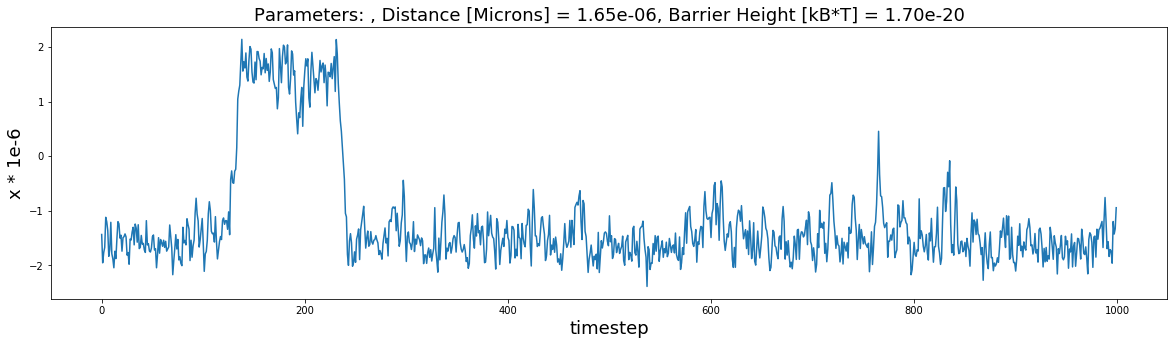

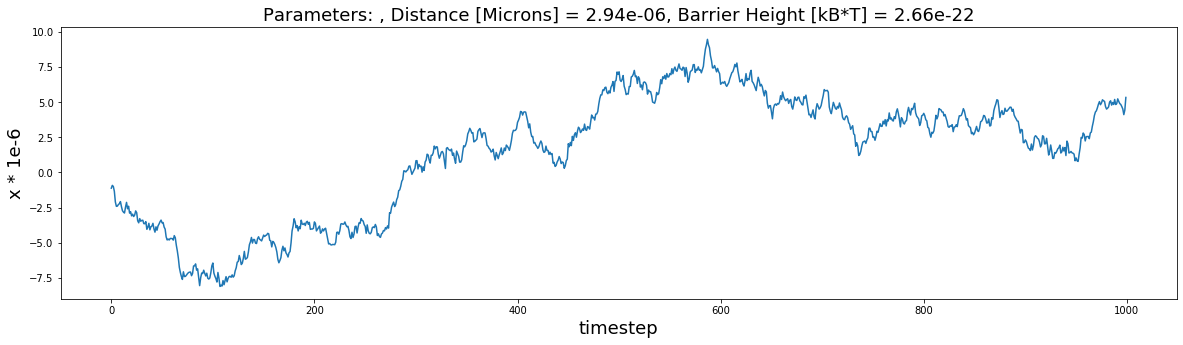

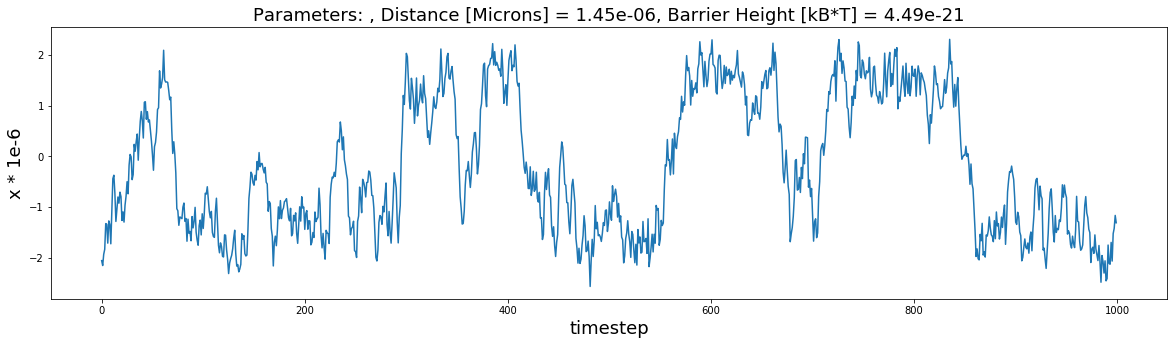

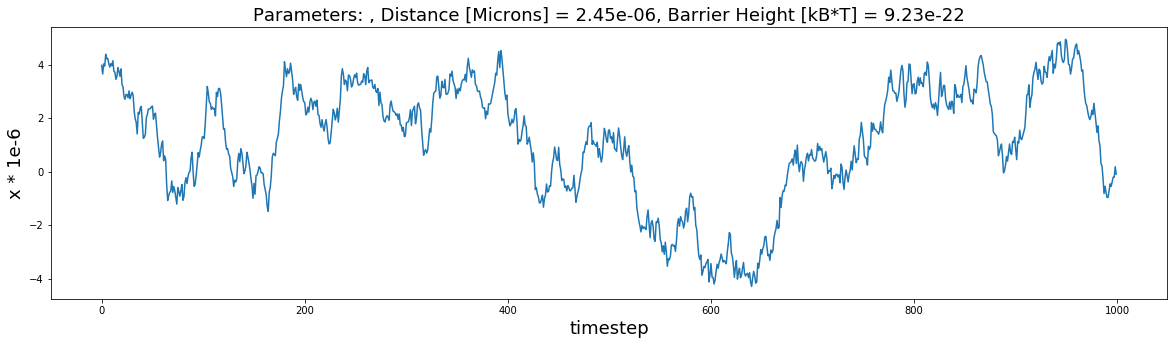

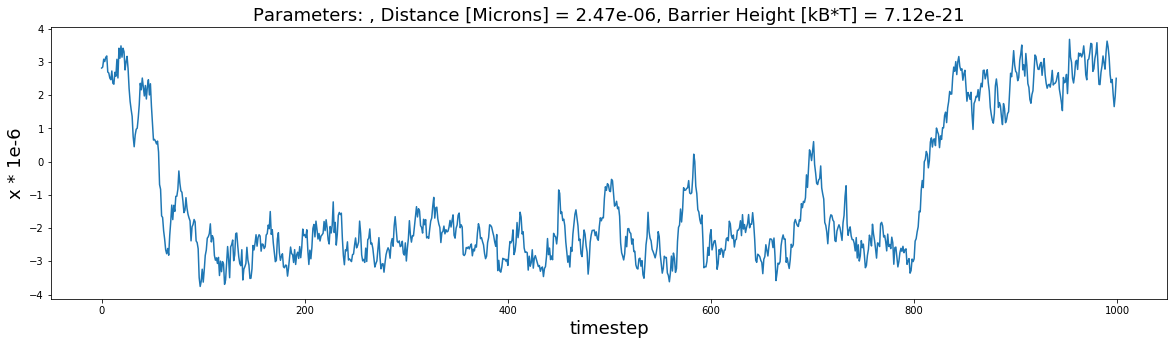

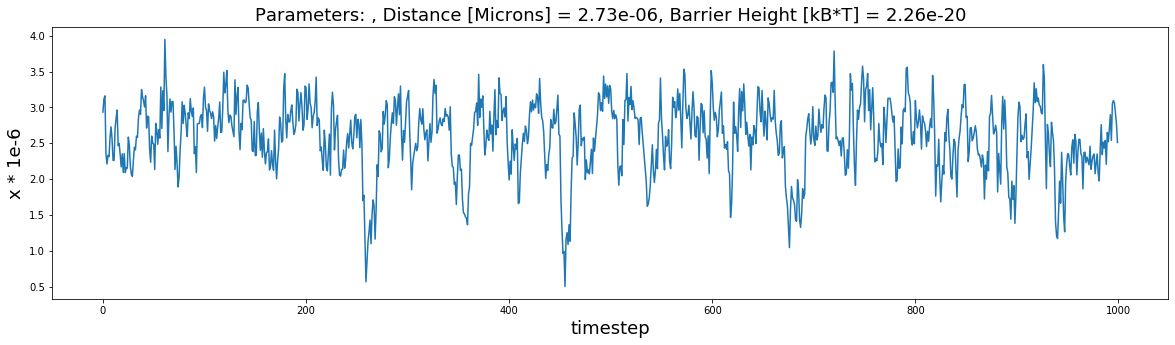

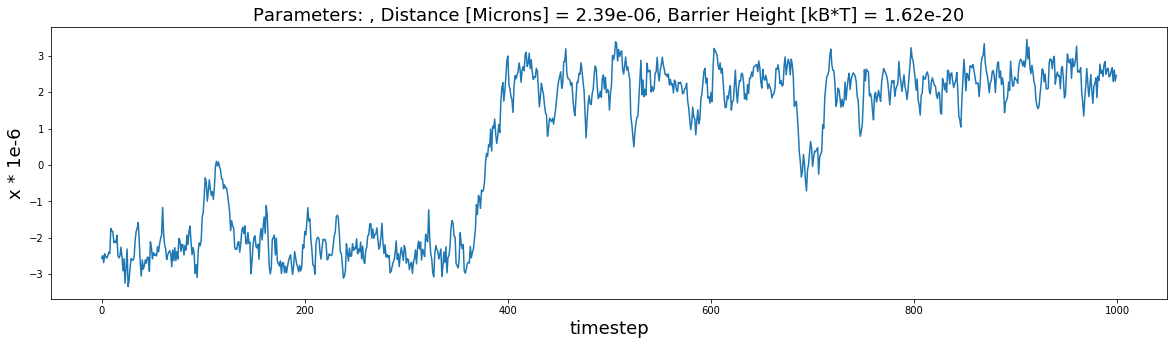

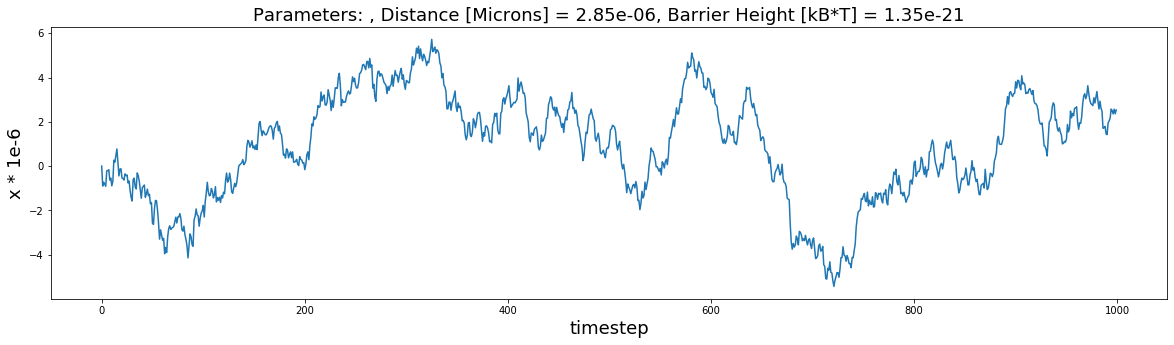

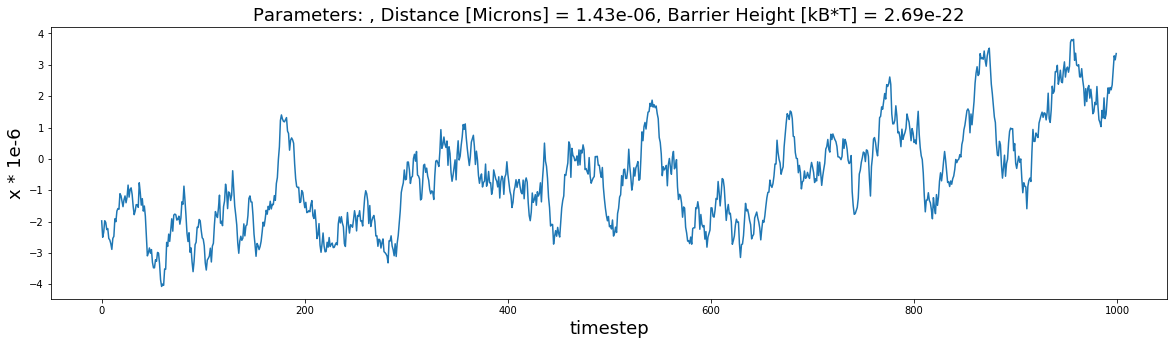

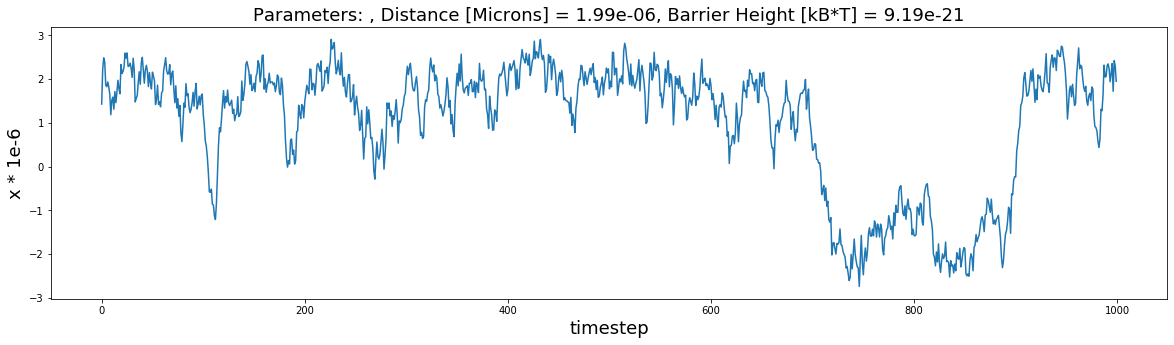

In [3]:
### Show some examples of simulated trajectories

number_of_trajectories_to_show = 10

%matplotlib inline
DeepCalib.plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show)

## 4. CREATE AND COMPILE DEEP LEARNING NETWORK

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.  

Comments:
1. The parameter <strong>input_shape</strong> determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 2 x 500 = 1000.
2. The parmameter <strong>conv_layers_dimensions</strong> determines the number and size of LSTM layers.
3. The parameter <strong>number_of_outputs</strong> determines the number of outputs, i.e. the number of force field parameters to be estimated.

In [4]:
### Define parameters of the deep learning network
input_shape = (2, 500)      
lstm_layers_dimensions = (1000, 250, 50)
number_of_outputs = 2

### Create deep learning network
network = DeepCalib.create_deep_learning_network(input_shape, lstm_layers_dimensions, number_of_outputs)

### Print deep learning network summary
network.summary()

C:\Users\Aykut\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Aykut\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Aykut\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Aykut\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

C:\Users\Aykut\Miniconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Aykut\Miniconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Aykut\Miniconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Aykut\Miniconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dty


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2, 1000)           6004000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 250)            1251000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                60200     
_________________________________________________________________
output (Dense)               (None, 2)                 102       
Total params: 7,315,302
Trainable params: 7,315,302
Non-trainable params: 0
_________________________________________________________________


## 5. TRAIN DEEP LEARNING NETWORK

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:
1. The parameter <strong>sample_sizes</strong> determines the sizes of the batches of trajectories used in the training.
2. The parameter <strong>iteration_numbers</strong> determines the numbers of batches used in the training.
3. The parameter <strong>verbose</strong> determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [5]:
## Define parameters of the training
sample_sizes = (8, 32, 128, 512, 2048)
iteration_numbers = (1001, 1001, 1001, 2001, 4001)

verbose = .1

### Training
training_history = DeepCalib.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers, verbose)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Sample size      8   iteration number      1   MSE     1.6208   MAE     0.9541   Time 5991.434336 ms
Sample size      8   iteration number     11   MSE     1.2972   MAE     0.7971   Time 281.198740 ms
Sample size     32   iteration number      1   MSE     1.3517   MAE     0.8313   Time 341.564894 ms


KeyboardInterrupt: 

## 6. PLOT LEARNING PERFORMANCE

The learning performance is plotted. The MSE, MAE, sample size, iteration number and iteration time are plotted against the number of timesteps. 

Comment:
1. The parameter <strong>number_of_timesteps_for_average</strong> determines the length of the average. It must be a positive integer number.

In [ ]:
### Plot learning performance
number_of_timesteps_for_average = 100

DeepCalib.plot_learning_performance(training_history, number_of_timesteps_for_average)

## 7. TEST DEEP LEARNING NETWORK ON NEW SIMULATED TRAJECTORIES

The deep learning network is tested on new simulated trajectories (parameters are defined in [section 2](#sec2)). The predicted values of the targets are plotted as function of their ground-truth values both in scaled and physical units.

Comments:
1. The parameter <strong>number_of_predictions_to_show</strong> determines the number of predictions that are shown.

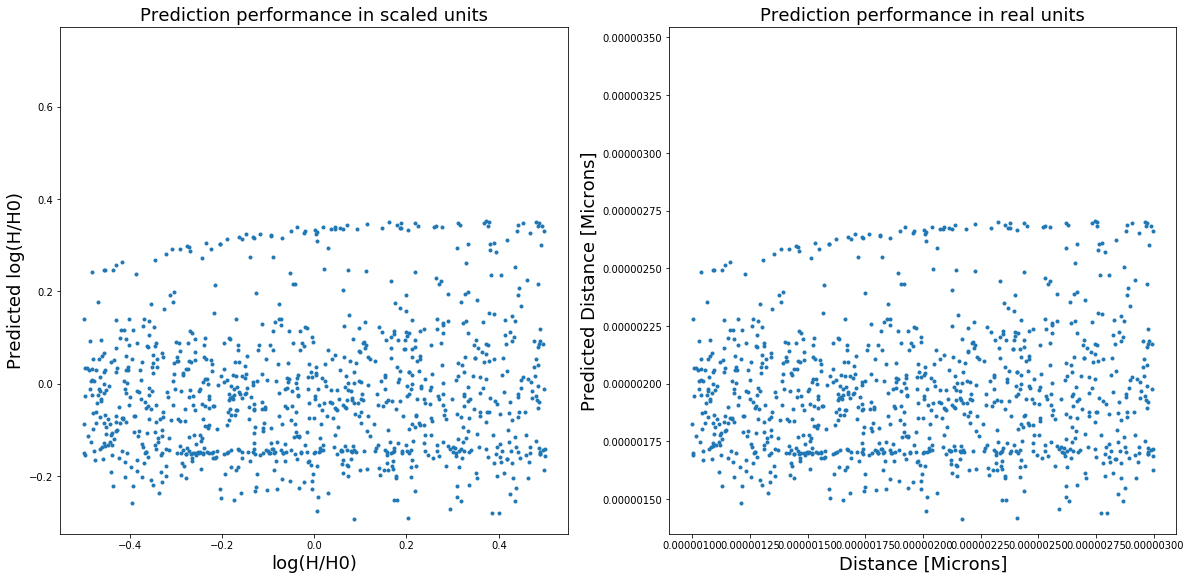

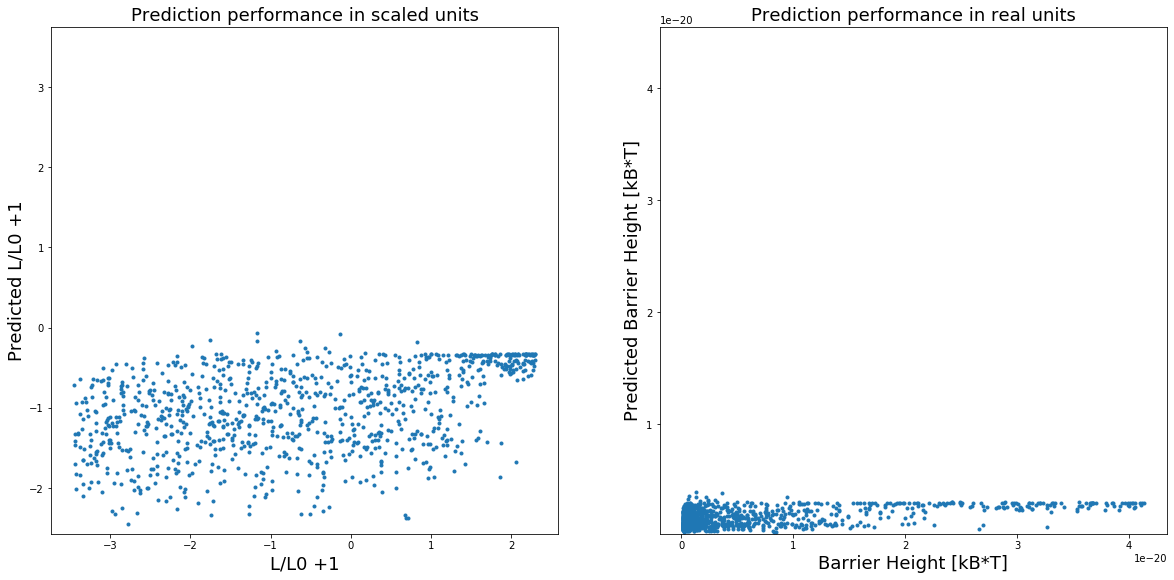

In [6]:
### Test the predictions of the deep learning network on some generated trajectories
number_of_predictions_to_show = 1000

%matplotlib inline
DeepCalib.plot_test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

## 9. SAVE DEEP LEARNING NETWORK

Comments:
1. The parameter <strong>save_file_name</strong> is the name of the file where the deep learnign network is saved.
2. By default, the network is saved in the same folder where DeepCalib is running.

In [ ]:
save_file_name = 'Network_Example_2a.h5'
network.save(save_file_name)